In [1]:
import torch
import torch.nn as nn
import math
import numpy as np
import pandas as pd
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
%matplotlib inline

### Input

Choose how many months out you would like to forecast by typing in the number of desired months below:

In [2]:
months_out = 6

In [3]:
df = pd.read_csv('/Users/colefairbanks/github/pytorch-profit-forecast/historical_tacorp_gp.csv',parse_dates=True)
#df = df.loc[(df['L20'] == 'TSS - IBM Logo Services') & (df['Kyndryl'] == 'N') & (df['Date'] > '2016-12-31')]
#df = df[['Date','gross']]
#df = df.groupby('Date').sum().reset_index(drop=False)
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df.head()

,gross_profit
Date,
2017-01-01,182.040325
2017-02-01,155.771318
2017-03-01,207.994962
2017-04-01,181.433241
2017-05-01,154.729654


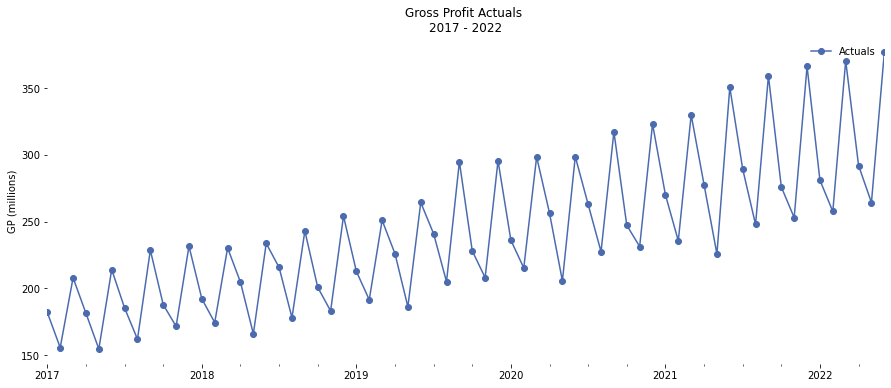

In [4]:
year_begin = df.index.year[0].astype(str)
year_end = df.index.year[-1].astype(str)

title='Gross Profit Actuals \n' + year_begin + ' - ' + year_end
ylabel='GP (millions)'
xlabel=''
    
plt = df['gross_profit'].plot(legend=True,figsize=(15,6),title=title,label='Actuals',marker='o',color='#4B6BAF')
    
plt.autoscale(axis='x',tight=True)
plt.set(xlabel=xlabel, ylabel=ylabel)
plt.spines['top'].set_visible(False)
plt.spines['bottom'].set_visible(False)
plt.spines['left'].set_visible(False)
plt.spines['right'].set_visible(False)
plt.legend(frameon=False);

## Prepare & Normalizing Data
In the next steps we'll divide the data into train/test sets, then normalize the training values so that they fall between -1 and 1 (to improve training). We'll train the model, then predict into a period that matches the test set. Finally, we'll forecast into an unknown future.

In [5]:
# converting GP y values into a numpy array
y = df['gross_profit'].values.astype(float)

# Making the test size equivalent to the number of months out we want to forecast
test_size = months_out

# Creating train and test sets
train_set = y[:-test_size]
test_set = y[-test_size:]

In [6]:
# Instantiating a scaler with a feature range from -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))

# Normalizing the training set
train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

## Prepare data for LSTM
Here we'll create our list of (seq/label) tuples from the training set. Recall that an LSTM consumes a window of samples toward the first prediction, so the size of our training set will become ((325 - test_size) - window_size).

In [7]:
# Convert train_norm from an array to a tensor
train_norm = torch.FloatTensor(train_norm).view(-1)
train_norm

tensor([-0.7416, -0.9901, -0.4960, -0.7474, -1.0000, -0.4379, -0.7098, -0.9306,
        -0.3005, -0.6861, -0.8399, -0.2722, -0.6452, -0.8127, -0.2846, -0.5275,
        -0.8933, -0.2525, -0.4231, -0.7789, -0.1645, -0.5637, -0.7307, -0.0589,
        -0.4507, -0.6516, -0.0892, -0.3259, -0.7015,  0.0368, -0.1848, -0.5239,
         0.3253, -0.3060, -0.4950,  0.3328, -0.2305, -0.4262,  0.3600, -0.0388,
        -0.5184,  0.3616,  0.0232, -0.3114,  0.5374, -0.1247, -0.2748,  0.5929,
         0.0915, -0.2340,  0.6569,  0.1631, -0.3277,  0.8527,  0.2741, -0.1186,
         0.9330,  0.1470, -0.0704,  1.0000])

In [8]:
# Define function to create sequence/label tuples
def input_data(sequence,months_out):  # months_out is the window size
    output = []
    sequence_length = len(sequence)
    for i in range(sequence_length-months_out):
        window = sequence[i:i+months_out]
        label = sequence[i+months_out:i+months_out+1]
        output.append((window,label))
    return output

In [9]:
# Apply the input_data function to train_norm
train_data = input_data(train_norm,months_out)
len(train_data) 

54

## Defining the LSTM Model

Our model will have one LSTM layer with an input size of 1 and a hidden size of 50, followed by a fully-connected layer to reduce the output to the prediction size of 1.<br>

During training we pass three tensors through the LSTM layer - the sequence, the hidden state $h_0$ and the cell state $c_0$.<br>

This means we need to initialize $h_0$ and $c_0$. This can be done with random values, but we'll use zeros instead.

In [10]:
class LSTMnetwork(nn.Module):
    
    def __init__(self,input_size=1,hidden_size=100,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]  # we only want the last value

## Instantiate the model, define loss and optimization functions

In [11]:
model = LSTMnetwork()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Training Model

In [12]:
epochs = 300
losses = []

for i in range(epochs):
    
    for sequence, y_train in train_data:
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        # apply the model
        y_pred = model(sequence)

        # update parameters
        loss = criterion(y_pred, y_train)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

In [14]:
# Add the last window of training values to the list of predictions
predictions_norm = train_norm[-months_out:].tolist()

# Set the model to evaluation mode
model.eval()

for i in range(months_out):
    sequence = torch.FloatTensor(predictions_norm[-months_out:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        predictions_norm.append(model(sequence).item())

In [15]:
# Display predicted values
predictions_norm[months_out:]    # equivalent to predictions[-future:]

[0.3788626492023468,
 0.057530660182237625,
 1.0270860195159912,
 0.18778982758522034,
 0.10623270273208618,
 1.053330659866333]

In [16]:
test_predictions = scaler.inverse_transform(np.array(predictions_norm[months_out:]).reshape(-1, 1))

In [17]:
test2 = pd.DataFrame(test_predictions, columns = ['Test'])

In [18]:
test = df.tail(6).reset_index(drop=False)

In [19]:
test3 = pd.concat([test, test2],axis=1)

In [20]:
test3 = test3.set_index('Date')

In [21]:
mse = mean_squared_error(test3['gross_profit'], test3['Test'])

In [22]:
loss

tensor(0.0003, grad_fn=<MseLossBackward0>)

In [23]:
rmse = math.sqrt(mse)

In [24]:
mape = mean_absolute_percentage_error(test3['gross_profit'], test3['Test'])

In [25]:
accuracy = 1 - mape

In [26]:
accuracy

0.9686432373771453

,gross_profit,Test
Date,,
2022-01-01,280.961379,300.468158
2022-02-01,257.615095,266.505063
2022-03-01,370.342345,368.981946
2022-04-01,291.952186,280.272769
2022-05-01,264.308767,271.652612
2022-06-01,376.553216,371.755866


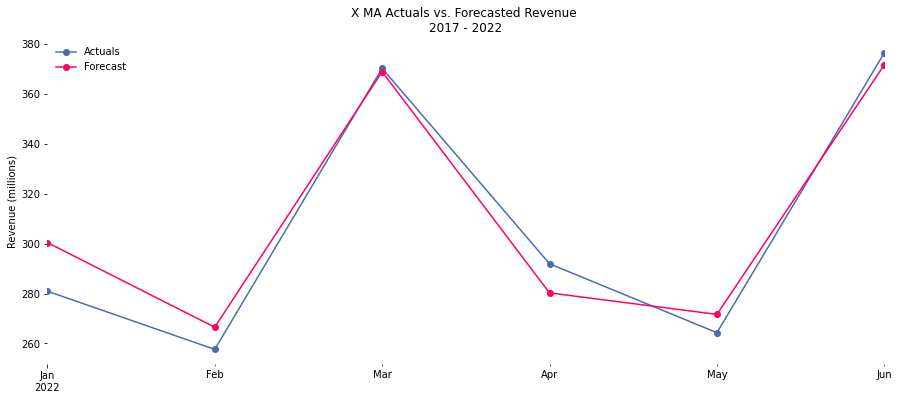

In [27]:
title='X MA Actuals vs. Forecasted Revenue \n' + year_begin + ' - ' + year_end
ylabel='Revenue (millions)'
xlabel=''
    
ax = test3['gross_profit'].plot(legend=True,figsize=(15,6),title=title,label='Actuals',marker='o',color='#4B6BAF')
ax2 = test3['Test'].plot(legend=True, label='Forecast',marker='o',color='#FF0066')
    
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(frameon=False);

test3.tail(6)

In [28]:
print(accuracy)

0.9686432373771453


In [29]:
input_data(y_norm,months_out)

NameError: name 'y_norm' is not defined

In [31]:
y

array([182.0403249, 155.7713184, 207.9949616, 181.4332405, 154.7296542,
       214.1361932, 185.3974841, 162.0665933, 228.6680772, 187.9115312,
       171.6557583, 231.6510342, 192.2342344, 174.5294363, 230.3478486,
       204.6754719, 166.0099881, 233.7315733, 215.7028089, 178.0970989,
       243.041732 , 200.8400688, 183.1948141, 254.1958339, 212.7904647,
       191.5542773, 250.9941908, 225.973639 , 186.2846609, 264.3130487,
       240.8919616, 205.0555576, 294.8078591, 228.0816551, 208.1009484,
       295.6006733, 236.0565997, 215.3779743, 298.4717771, 256.3228364,
       205.6361143, 298.644595 , 262.8740754, 227.5109228, 317.2257013,
       247.24698  , 231.381    , 323.092565 , 270.09338  , 235.686606 ,
       329.852757 , 277.666696 , 225.787131 , 350.549153 , 289.397963 ,
       247.884218 , 359.039579 , 275.956546 , 252.984243 , 366.119097 ,
       280.961379 , 257.615095 , 370.342345 , 291.9521862, 264.3087666,
       376.5532157])

In [49]:
y_norm

tensor([-0.7538, -0.9906, -0.5198, -0.7592, -1.0000, -0.4644, -0.7235, -0.9338,
        -0.3334, -0.7008, -0.8474, -0.3065, -0.6619, -0.8215, -0.3182, -0.5497,
        -0.8983, -0.2877, -0.4503, -0.7893, -0.2038, -0.5843, -0.7434, -0.1032,
        -0.4765, -0.6680, -0.1321, -0.3577, -0.7155, -0.0120, -0.2231, -0.5463,
         0.2630, -0.3386, -0.5188,  0.2701, -0.2667, -0.4532,  0.2960, -0.0840,
        -0.5410,  0.2976, -0.0250, -0.3438,  0.4651, -0.1658, -0.3089,  0.5180,
         0.0401, -0.2701,  0.5789,  0.1084, -0.3593,  0.7655,  0.2142, -0.1601,
         0.8421,  0.0930, -0.1141,  0.9059,  0.1381, -0.0724,  0.9440,  0.2372,
        -0.0120,  1.0000])

In [50]:
y

array([182.0403249, 155.7713184, 207.9949616, 181.4332405, 154.7296542,
       214.1361932, 185.3974841, 162.0665933, 228.6680772, 187.9115312,
       171.6557583, 231.6510342, 192.2342344, 174.5294363, 230.3478486,
       204.6754719, 166.0099881, 233.7315733, 215.7028089, 178.0970989,
       243.041732 , 200.8400688, 183.1948141, 254.1958339, 212.7904647,
       191.5542773, 250.9941908, 225.973639 , 186.2846609, 264.3130487,
       240.8919616, 205.0555576, 294.8078591, 228.0816551, 208.1009484,
       295.6006733, 236.0565997, 215.3779743, 298.4717771, 256.3228364,
       205.6361143, 298.644595 , 262.8740754, 227.5109228, 317.2257013,
       247.24698  , 231.381    , 323.092565 , 270.09338  , 235.686606 ,
       329.852757 , 277.666696 , 225.787131 , 350.549153 , 289.397963 ,
       247.884218 , 359.039579 , 275.956546 , 252.984243 , 366.119097 ,
       280.961379 , 257.615095 , 370.342345 , 291.9521862, 264.3087666,
       376.5532157])

In [32]:
epochs = 300

# set model to back to training mode
model.train()

# feature scale the entire dataset
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm,months_out)

import time
start_time = time.time()

for epoch in range(epochs):
    
    # train on the full set of sequences
    for seq, y_train in all_data:  
        
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        y_pred = model(seq)
        
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    # print training result
    print(f'Epoch: {epoch+1:2} Loss: {loss.item():10.8f}')
    
#print(f'\nDuration: {time.time() - start_time:.0f} seconds')

Epoch:  1 Loss: 0.00006076
Epoch:  2 Loss: 0.00005822
Epoch:  3 Loss: 0.00004765
Epoch:  4 Loss: 0.00003031
Epoch:  5 Loss: 0.00001111
Epoch:  6 Loss: 0.00000003
Epoch:  7 Loss: 0.00001640
Epoch:  8 Loss: 0.00008687
Epoch:  9 Loss: 0.00020452
Epoch: 10 Loss: 0.00022419
Epoch: 11 Loss: 0.00002586
Epoch: 12 Loss: 0.00028155
Epoch: 13 Loss: 0.00172347
Epoch: 14 Loss: 0.00382951
Epoch: 15 Loss: 0.00775450
Epoch: 16 Loss: 0.01036947
Epoch: 17 Loss: 0.00012177
Epoch: 18 Loss: 0.00813470
Epoch: 19 Loss: 0.00011309
Epoch: 20 Loss: 0.00102564
Epoch: 21 Loss: 0.00000460
Epoch: 22 Loss: 0.00073418
Epoch: 23 Loss: 0.00040500
Epoch: 24 Loss: 0.00012606
Epoch: 25 Loss: 0.00011472
Epoch: 26 Loss: 0.00026669
Epoch: 27 Loss: 0.00046538
Epoch: 28 Loss: 0.00014588
Epoch: 29 Loss: 0.00006065
Epoch: 30 Loss: 0.00004853
Epoch: 31 Loss: 0.00013939
Epoch: 32 Loss: 0.00012373
Epoch: 33 Loss: 0.00010788
Epoch: 34 Loss: 0.00001589
Epoch: 35 Loss: 0.00003095
Epoch: 36 Loss: 0.00003451
Epoch: 37 Loss: 0.00014842
E

Epoch: 299 Loss: 0.00000256
Epoch: 300 Loss: 0.00000188

Duration: 38 seconds


In [44]:
predictions = y[-months_out:].tolist()

for i in range(months_out):  
    sequence = torch.FloatTensor(predictions[-months_out:])
    with torch.no_grad():
        # Reset the hidden parameters
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))  
        predictions.append(model(sequence).item())

In [51]:
window_size = 6
future = 6
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()
for i in range(future):  
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        # Reset the hidden parameters here!
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))  
        preds.append(model(seq).item())

# Inverse-normalize the prediction set
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

In [46]:
#predictions = scaler.inverse_transform(np.array(predictions[months_out:]).reshape(-1, 1))

In [52]:
true_predictions.tolist()

[[280.96137944853376],
 [257.61509477405457],
 [370.34234171664644],
 [291.9521858688826],
 [264.30876658625783],
 [376.55321569999995],
 [293.376318232229],
 [271.78578263687814],
 [378.8068040643286],
 [290.13674694607704],
 [276.2340991844486],
 [378.1887417942906]]

In [39]:
test4 = pd.DataFrame(predictions, columns = ['Forecast'])

In [40]:
test4

,Forecast
0,206.107419
1,233.683724
2,219.601908
3,199.686988
4,215.459690
5,195.097730
